# Hilbert-Schmidt Independence Criterion (HSIC)

In [74]:
import sys
sys.path.append("../../../")

import objax
import jax
import jax.numpy as np

from jaxkern.kernels.stationary import RBF
from jaxkern.kernels.linear import Linear
from jaxkern.similarity.hsic import HSIC, CKA, HSICRBF, CKARBF
from jaxkern.kernels.sigma import estimate_sigma_median
from jaxkern.kernels.linear import linear_kernel
from jaxkern.kernels.utils import kernel_matrix
from jaxkern.similarity.hsic import (
    hsic_u_statistic_einsum, hsic_u_statistic_dot, 
    hsic_v_statistic_einsum, hsic_v_statistic_trace
) 
from jaxkern.data.similarity import generate_data

# 
import numpy as onp

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

## Benchmarks

### U-Statistic

In [84]:
import tqdm

samples = [10, 100, 500, 1_000, 2_000, 5_000, 10_000]
n_features = 10

rng = onp.random.RandomState(123)


results_samples = {
    "ustat_einsum": [],
    "ustat_einsum_mu": [],
    "ustat_einsum_std": [],
    "ustat_dot": [],
    "ustat_dot_mu": [],
    "ustat_dot_std": [],
    "ustat_jitted_einsum_mu": [],
    "ustat_jitted_einsum_std": [],
    "ustat_jitted_dot_mu": [],
    "ustat_jitted_dot_std": [],
}

pbar = tqdm.tqdm(samples)

for i_samples in pbar:
    
    # generate sample data
    X = rng.normal(size=(i_samples, n_features))
    Y = X @ rng.uniform(size=(n_features, n_features))
    
    # calculate the kernel matrices
    K_x = kernel_matrix(linear_kernel, np.array(X), np.array(X))
    K_y = kernel_matrix(linear_kernel, np.array(Y), np.array(Y))
    
    # calculate the h
    t = %timeit -o hsic_u_statistic_einsum(K_x.block_until_ready(), K_y.block_until_ready())
    

    results_samples["ustat_einsum"].append(hsic_u_statistic_einsum(K_x, K_y))
    results_samples["ustat_einsum_mu"].append(t.average)
    results_samples["ustat_einsum_std"].append(t.stdev)

    jitted = jax.jit(hsic_u_statistic_einsum)
    _ = jitted(K_x, K_y)
    
    t = %timeit -o jitted(K_x.block_until_ready(), K_y.block_until_ready())
    
    results_samples["ustat_jitted_einsum_mu"].append(t.average)
    results_samples["ustat_jitted_einsum_std"].append(t.stdev)
    
    # calculate the kernel matrices
    K_x = kernel_matrix(linear_kernel, np.array(X), np.array(X))
    K_y = kernel_matrix(linear_kernel, np.array(Y), np.array(Y))

    # calculate the h
    t = %timeit -o hsic_u_statistic_dot(K_x.block_until_ready(), K_y.block_until_ready())
    
    results_samples["ustat_dot"].append(hsic_u_statistic_fast(K_x, K_y))
    results_samples["ustat_dot_mu"].append(t.average)
    results_samples["ustat_dot_std"].append(t.stdev)
    
    
    jitted = jax.jit(hsic_u_statistic_dot)
    _ = jitted(K_x, K_y)
    
    t = %timeit -o jitted(K_x.block_until_ready(), K_y.block_until_ready())
    
    results_samples["ustat_jitted_dot_mu"].append(t.average)
    results_samples["ustat_jitted_dot_std"].append(t.stdev)


  0%|          | 0/7 [00:00<?, ?it/s]

1.84 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
233 µs ± 2.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.14 ms ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 14%|█▍        | 1/7 [00:12<01:16, 12.78s/it]

227 µs ± 662 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.72 ms ± 20.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
220 µs ± 275 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.19 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 29%|██▊       | 2/7 [00:38<01:22, 16.53s/it]

248 µs ± 16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.27 ms ± 38.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.57 ms ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.84 ms ± 71.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 43%|████▎     | 3/7 [01:02<01:16, 19.03s/it]

2.75 ms ± 72.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.88 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.49 ms ± 38.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.8 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 57%|█████▋    | 4/7 [01:34<01:08, 22.72s/it]

8.16 ms ± 60.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32 ms ± 3.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.2 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
85.7 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 71%|███████▏  | 5/7 [02:39<01:11, 35.59s/it]

53.7 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 21.68 times longer than the fastest. This could mean that an intermediate result is being cached.
269 ms ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
210 ms ± 7.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
601 ms ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 86%|████████▌ | 6/7 [03:32<00:40, 40.69s/it]

361 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 24.09 times longer than the fastest. This could mean that an intermediate result is being cached.
941 ms ± 366 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
854 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.74 s ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


100%|██████████| 7/7 [05:24<00:00, 46.29s/it]

The slowest run took 463.95 times longer than the fastest. This could mean that an intermediate result is being cached.
71.6 ms ± 91.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


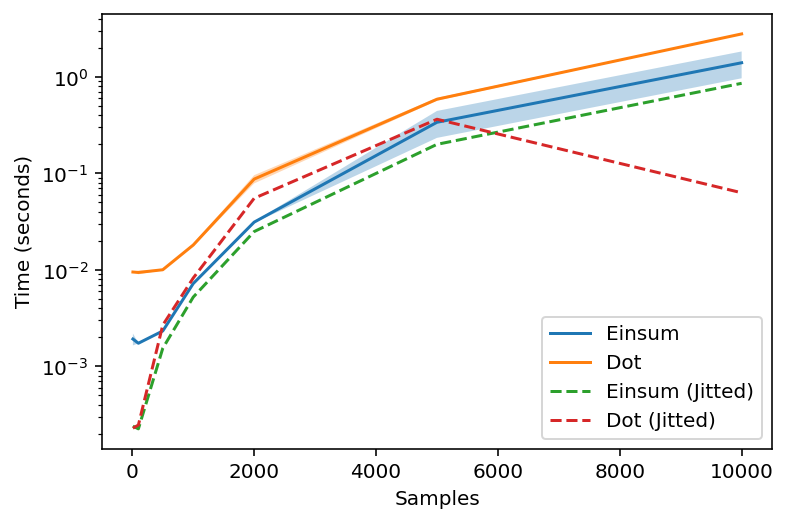

In [83]:
plt.figure()

plt.plot(samples, results_samples["ustat_einsum_mu"], label="Einsum")
plt.fill_between(
    samples, 
    np.stack(results_samples["ustat_einsum_mu"]) - np.stack(results_samples["ustat_einsum_std"]),
    np.stack(results_samples["ustat_einsum_mu"]) + np.stack(results_samples["ustat_einsum_std"]),
    alpha=0.3
)
plt.plot(samples, results_samples["ustat_dot_mu"], label="Dot")
plt.fill_between(
    samples, 
    np.stack(results_samples["ustat_dot_mu"]) - np.stack(results_samples["ustat_dot_std"]),
    np.stack(results_samples["ustat_dot_mu"]) + np.stack(results_samples["ustat_dot_std"]),
    alpha=0.3
)

plt.plot(samples, results_samples["ustat_jitted_einsum_mu"], 
         label="Einsum (Jitted)",
         linestyle='--'
        )
# plt.fill_between(
#     samples, 
#     np.stack(results_samples["ustat_jitted_einsum_mu"]) - np.stack(results_samples["ustat_jitted_einsum_std"]),
#     np.stack(results_samples["ustat_jitted_einsum_mu"]) + np.stack(results_samples["ustat_jitted_einsum_std"]),
#     alpha=0.3
# )
plt.plot(samples, results_samples["ustat_jitted_dot_mu"], 
         label="Dot (Jitted)",
         linestyle='--'
        )
# plt.fill_between(
#     samples, 
#     np.stack(results_samples["ustat_jitted_dot_mu"]) - np.stack(results_samples["ustat_jitted_dot_std"]),
#     np.stack(results_samples["ustat_jitted_dot_mu"]) + np.stack(results_samples["ustat_jitted_dot_std"]),
#     alpha=0.3
# )
plt.xlabel("Samples")
plt.ylabel("Time (seconds)")
plt.yscale("Log")
plt.legend()

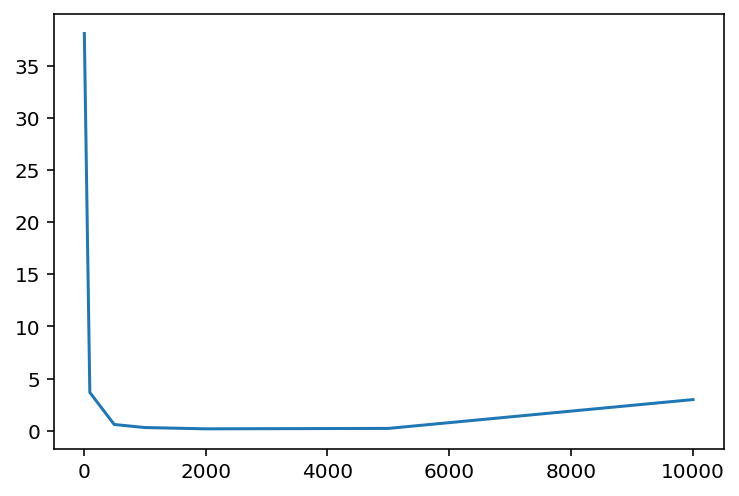

In [55]:
plt.plot(samples, np.abs(np.stack(results_samples["ustat_einsum"]) - np.stack(results_samples["ustat_dot"])))

In [23]:
import tqdm

n_samples = 1_000
features = [10, 20, 50, 100, 1_000]

rng = onp.random.RandomState(123)


results_features = {
    "ustat_einsum": [],
    "ustat_einsum_mu": [],
    "ustat_einsum_std": [],
    "ustat_dot": [],
    "ustat_dot_mu": [],
    "ustat_dot_std": [],
}

pbar = tqdm.tqdm(features)

for i_features in pbar:
    
    # generate sample data
    X = rng.normal(size=(n_samples, i_features))
    Y = X @ rng.uniform(size=(i_features, i_features))
    
    # calculate the kernel matrices
    K_x = kernel_matrix(linear_kernel, np.array(X), np.array(X))
    K_y = kernel_matrix(linear_kernel, np.array(Y), np.array(Y))
    
    # calculate the h
    t = %timeit -o hsic_u_statistic(K_x, K_y)
    
    results_features["ustat_einsum"].append(hsic_u_statistic(K_x, K_y))
    results_features["ustat_einsum_mu"].append(t.average)
    results_features["ustat_einsum_std"].append(t.stdev)
    
    # calculate the kernel matrices
    K_x = kernel_matrix(linear_kernel, np.array(X), np.array(X))
    K_y = kernel_matrix(linear_kernel, np.array(Y), np.array(Y))

    # calculate the h
    t = %timeit -o hsic_u_statistic_fast(K_x, K_y)
    
    results_features["ustat_dot"].append(hsic_u_statistic_fast(K_x, K_y))
    results_features["ustat_dot_mu"].append(t.average)
    results_features["ustat_dot_std"].append(t.stdev)


  0%|          | 0/5 [00:00<?, ?it/s]

7.8 ms ± 757 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 20%|██        | 1/5 [00:19<01:19, 19.88s/it]

16.5 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.96 ms ± 635 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 40%|████      | 2/5 [00:27<00:48, 16.29s/it]

17.2 ms ± 571 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.63 ms ± 485 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 60%|██████    | 3/5 [00:47<00:34, 17.33s/it]

16.4 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.22 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 80%|████████  | 4/5 [01:01<00:16, 16.46s/it]

16.6 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.92 ms ± 57 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


100%|██████████| 5/5 [01:06<00:00, 13.21s/it]

18 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


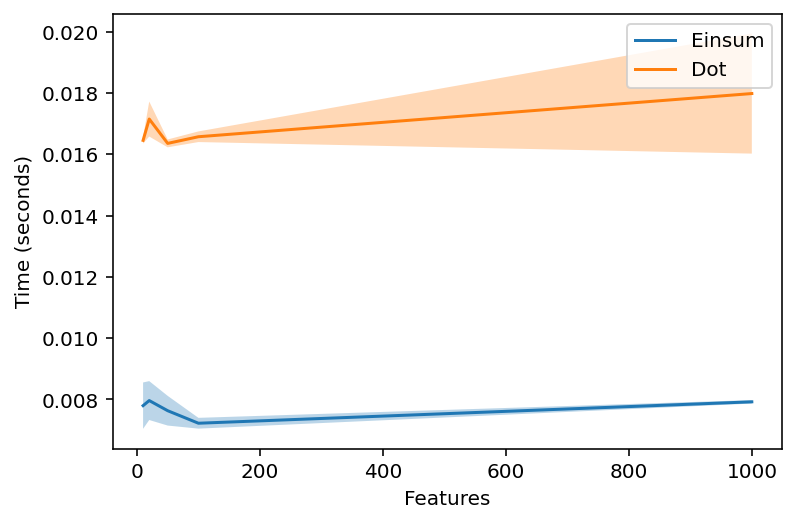

In [42]:
plt.plot(features, results_features["ustat_einsum_mu"], label="Einsum")
plt.fill_between(
    features, 
    np.stack(results_features["ustat_einsum_mu"]) - np.stack(results_features["ustat_einsum_std"]),
    np.stack(results_features["ustat_einsum_mu"]) + np.stack(results_features["ustat_einsum_std"]),
    alpha=0.3
)
plt.plot(features, results_features["ustat_dot_mu"], label="Dot")
plt.fill_between(
    features, 
    np.stack(results_features["ustat_dot_mu"]) - np.stack(results_features["ustat_dot_std"]),
    np.stack(results_features["ustat_dot_mu"]) + np.stack(results_features["ustat_dot_std"]),
    alpha=0.3
)
plt.xlabel("Features")
plt.ylabel("Time (seconds)")
plt.legend()

In [57]:
np.stack(results_features["ustat_einsum"]), np.stack(results_features["ustat_dot"])

(DeviceArray([3.6455811e+01, 1.4095053e+02, 8.1969214e+02, 3.4948860e+03,
              6.8672881e+05], dtype=float32),
 DeviceArray([3.6097672e+01, 1.3821849e+02, 7.7936261e+02, 3.1682917e+03,
              3.5120122e+05], dtype=float32))

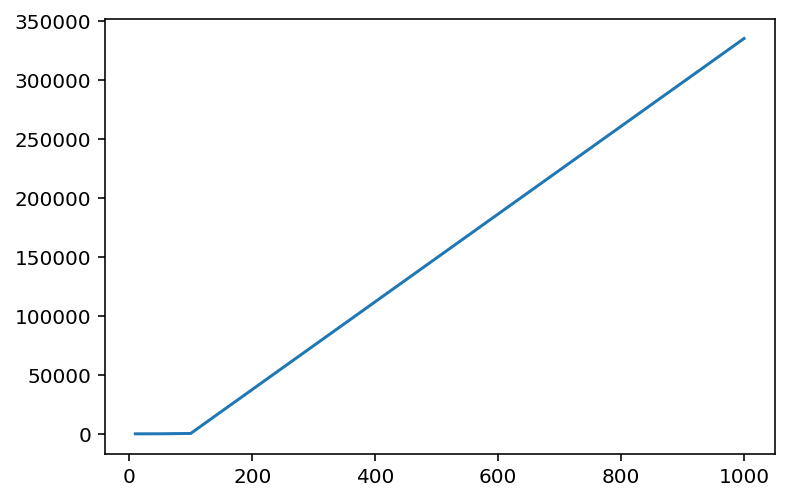

In [58]:
plt.plot(features, np.abs(np.stack(results_features["ustat_einsum"]) - np.stack(results_features["ustat_dot"])))

## V-Statistic


**Option I**

$$
\text{HSIC}_{v}(\mathbf{X,Y}) = \\ 
\frac{1}{N^2} \sum_{ij}^N \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{ij}} 
+ \frac{1}{N^4} \sum_{ijkl}^N \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{kl}} 
- \frac{2}{N^3} \sum_{ijk}^N \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{ik}}
$$

**Option II**

In [59]:
from jaxkern.similarity.hsic import hsic_v_statistic, hsic_v_statistic_faster

### Samples Comparison

In [60]:
import tqdm

samples = [10, 100, 500, 1_000, 2_000, 5_000, 10_000]
n_features = 10

rng = onp.random.RandomState(123)


results_samples = {
    "vstat_einsum": [],
    "vstat_einsum_mu": [],
    "vstat_einsum_std": [],
    "vstat_trace": [],
    "vstat_trace_mu": [],
    "vstat_trace_std": [],
}

pbar = tqdm.tqdm(samples)

for i_samples in pbar:
    
    # generate sample data
    X = rng.normal(size=(i_samples, n_features))
    Y = X @ rng.uniform(size=(n_features, n_features))
    
    # calculate the kernel matrices
    K_x = kernel_matrix(linear_kernel, np.array(X), np.array(X))
    K_y = kernel_matrix(linear_kernel, np.array(Y), np.array(Y))
    
    # calculate the h
    t = %timeit -o hsic_v_statistic(K_x, K_y)
    
    results_samples["vstat_einsum"].append(hsic_v_statistic(K_x, K_y))
    results_samples["vstat_einsum_mu"].append(t.average)
    results_samples["vstat_einsum_std"].append(t.stdev)
    
    # calculate the kernel matrices
    K_x = kernel_matrix(linear_kernel, np.array(X), np.array(X))
    K_y = kernel_matrix(linear_kernel, np.array(Y), np.array(Y))

    # calculate the h
    t = %timeit -o hsic_v_statistic_faster(K_x, K_y)
    
    results_samples["vstat_trace"].append(hsic_v_statistic_faster(K_x, K_y))
    results_samples["vstat_trace_mu"].append(t.average)
    results_samples["vstat_trace_std"].append(t.stdev)

  0%|          | 0/7 [00:00<?, ?it/s]

2.03 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 14%|█▍        | 1/7 [00:04<00:27,  4.62s/it]

3.45 ms ± 31.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.91 ms ± 3.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


 29%|██▊       | 2/7 [00:23<00:44,  8.80s/it]

3.75 ms ± 12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.28 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 43%|████▎     | 3/7 [00:30<00:32,  8.21s/it]

5.81 ms ± 70.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.29 ms ± 45.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 57%|█████▋    | 4/7 [00:50<00:35, 11.86s/it]

17.6 ms ± 66.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
30.7 ms ± 426 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 71%|███████▏  | 5/7 [00:59<00:21, 10.96s/it]

75.1 ms ± 902 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
274 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
847 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 86%|████████▌ | 6/7 [01:29<00:16, 16.61s/it]

1.24 s ± 189 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.02 s ± 402 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


100%|██████████| 7/7 [02:22<00:00, 20.32s/it]


#### Viz - Speed

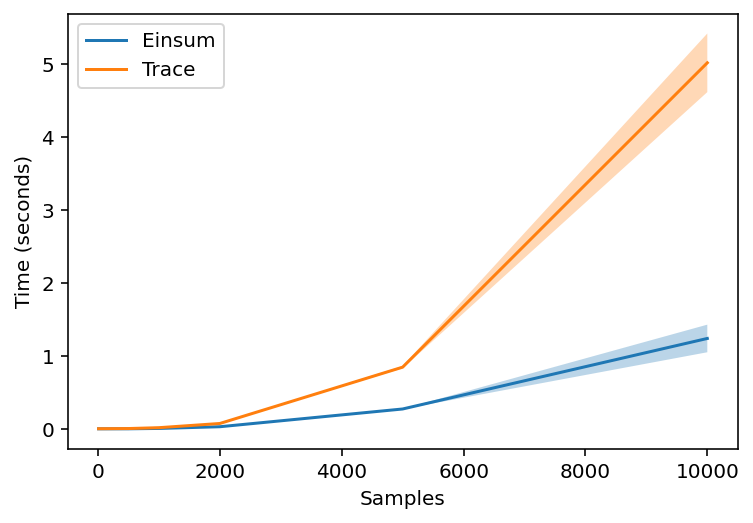

In [62]:
plt.plot(samples, results_samples["vstat_einsum_mu"], label="Einsum")
plt.fill_between(
    samples, 
    np.stack(results_samples["vstat_einsum_mu"]) - np.stack(results_samples["vstat_einsum_std"]),
    np.stack(results_samples["vstat_einsum_mu"]) + np.stack(results_samples["vstat_einsum_std"]),
    alpha=0.3
)
plt.plot(samples, results_samples["vstat_trace_mu"], label="Trace")
plt.fill_between(
    samples, 
    np.stack(results_samples["vstat_trace_mu"]) - np.stack(results_samples["vstat_trace_std"]),
    np.stack(results_samples["vstat_trace_mu"]) + np.stack(results_samples["vstat_trace_std"]),
    alpha=0.3
)
plt.xlabel("Samples")
plt.ylabel("Time (seconds)")
plt.legend()

#### Viz - Accuracy

In [64]:
np.stack(results_samples["vstat_einsum"]), np.stack(results_samples["vstat_trace"])

(DeviceArray([85.48953 , 50.623096, 31.140781, 32.12795 , 39.668343,
              33.26644 , 35.141884], dtype=float32),
 DeviceArray([85.489525, 50.623123, 31.140907, 32.12757 , 39.66589 ,
              33.26636 , 35.14077 ], dtype=float32))

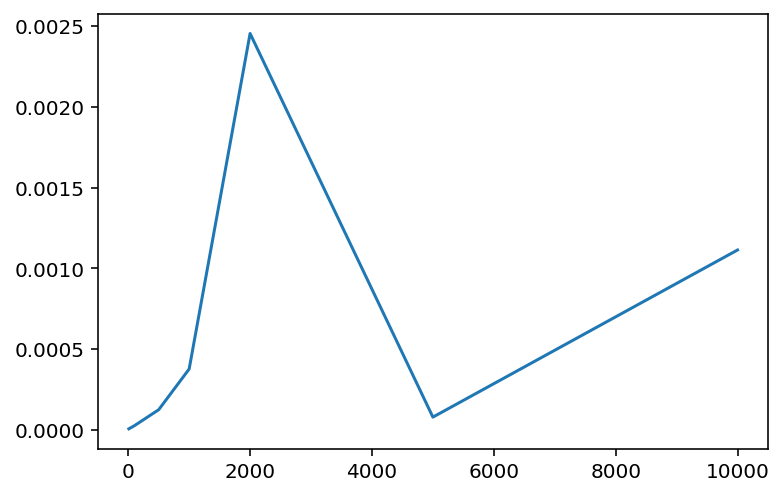

In [67]:
plt.plot(samples, np.abs(np.stack(results_samples["vstat_einsum"]) - np.stack(results_samples["vstat_trace"])))

### Features

In [70]:
import tqdm

n_samples = 1_000
features = [10, 20, 50, 100, 1_000]

rng = onp.random.RandomState(123)


results_features = {
    "vstat_einsum": [],
    "vstat_einsum_mu": [],
    "vstat_einsum_std": [],
    "vstat_trace": [],
    "vstat_trace_mu": [],
    "vstat_trace_std": [],
}

pbar = tqdm.tqdm(features)

for i_features in pbar:
    
    # generate sample data
    X = rng.normal(size=(n_samples, i_features))
    Y = X @ rng.uniform(size=(i_features, i_features))
    
    # calculate the kernel matrices
    K_x = kernel_matrix(linear_kernel, np.array(X), np.array(X))
    K_y = kernel_matrix(linear_kernel, np.array(Y), np.array(Y))
    
    # calculate the h
    t = %timeit -o hsic_v_statistic(K_x, K_y)
    
    results_features["vstat_einsum"].append(hsic_v_statistic(K_x, K_y))
    results_features["vstat_einsum_mu"].append(t.average)
    results_features["vstat_einsum_std"].append(t.stdev)
    
    # calculate the kernel matrices
    K_x = kernel_matrix(linear_kernel, np.array(X), np.array(X))
    K_y = kernel_matrix(linear_kernel, np.array(Y), np.array(Y))

    # calculate the h
    t = %timeit -o hsic_v_statistic_faster(K_x, K_y)
    
    results_features["vstat_trace"].append(hsic_v_statistic_faster(K_x, K_y))
    results_features["vstat_trace_mu"].append(t.average)
    results_features["vstat_trace_std"].append(t.stdev)


  0%|          | 0/5 [00:00<?, ?it/s]

7.86 ms ± 93.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 20%|██        | 1/5 [00:08<00:32,  8.07s/it]

18.1 ms ± 506 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.03 ms ± 27.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 40%|████      | 2/5 [00:16<00:24,  8.09s/it]

18.1 ms ± 632 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.8 ms ± 27.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 60%|██████    | 3/5 [00:24<00:16,  8.06s/it]

18 ms ± 698 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.64 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


 80%|████████  | 4/5 [00:26<00:06,  6.39s/it]

17.9 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.95 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


100%|██████████| 5/5 [00:31<00:00,  6.39s/it]

18.1 ms ± 577 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Viz - Speed

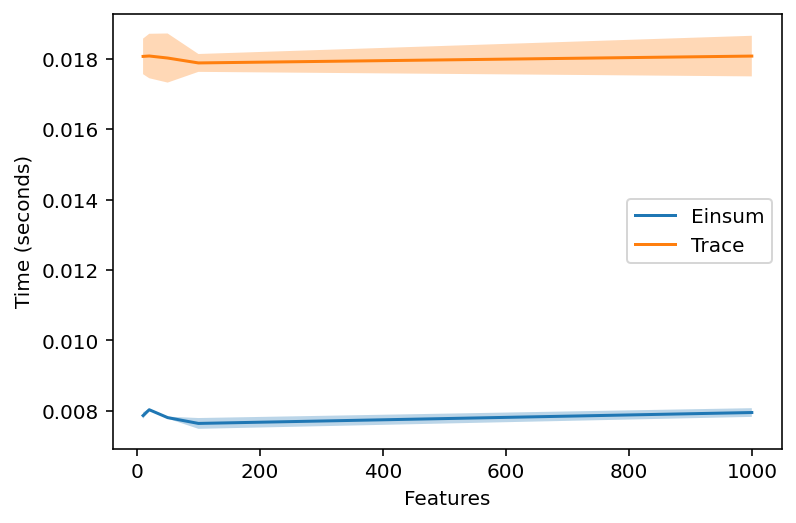

In [71]:
plt.plot(features, results_features["vstat_einsum_mu"], label="Einsum")
plt.fill_between(
    features, 
    np.stack(results_features["vstat_einsum_mu"]) - np.stack(results_features["vstat_einsum_std"]),
    np.stack(results_features["vstat_einsum_mu"]) + np.stack(results_features["vstat_einsum_std"]),
    alpha=0.3
)
plt.plot(features, results_features["vstat_trace_mu"], label="Trace")
plt.fill_between(
    features, 
    np.stack(results_features["vstat_trace_mu"]) - np.stack(results_features["vstat_trace_std"]),
    np.stack(results_features["vstat_trace_mu"]) + np.stack(results_features["vstat_trace_std"]),
    alpha=0.3
)
plt.xlabel("Features")
plt.ylabel("Time (seconds)")
plt.legend()

#### Viz - Accuracy

In [72]:
np.stack(results_features["vstat_einsum"]), np.stack(results_features["vstat_trace"])

(DeviceArray([3.6419483e+01, 1.4080975e+02, 8.1887408e+02, 3.4913950e+03,
              6.8604238e+05], dtype=float32),
 DeviceArray([3.6420563e+01, 1.4080614e+02, 8.1885437e+02, 3.4914111e+03,
              6.8605194e+05], dtype=float32))

In [ ]:
plt.plot(features, np.abs(np.stack(results_features["vstat_einsum"]) - np.stack(results_features["vstat_trace"])))

In [8]:
t.stdev, t.average

(0.016979063742629176, 0.09805082712721612)

In [14]:
t

<TimeitResult : 106 ms ± 6.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

### V-Statistic

$$
\text{HSIC}_{v}(\mathbf{X,Y}) = \frac{1}{N^2} \sum_{ij}^N \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{ij}} \\
+ \frac{1}{N^4} \sum_{ijkl}^N \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{kl}} \\
- \frac{2}{N^3} \sum_{ijk}^N \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{ik}}
$$

In [54]:
def hsic_v_statistic(K_x, K_y):
    n_samples = K_x.shape[0]
    A = np.einsum("ij,ij->", K_x, K_y) / n_samples ** 2
    B = np.einsum("ij,kl->", K_x, K_y) / n_samples ** 4
    C = np.einsum("ij,ik->", K_x, K_y) / n_samples ** 3
    return A + B - 2 * C

In [56]:
nhsic_v = nhsic_stat(hsic_v_statistic, K_x, K_y)

print(f"nHSIC (V-stat): {nhsic_v:.8f}")

nhsic_v = nhsic_stat(hsic_v_statistic, K_xc, K_yc)

print(f"nHSIC (V-stat, centered): {nhsic_v:.8f}")

nHSIC (V-stat): 0.89191633
nHSIC (V-stat, centered): 0.89092809


#### Faster Version

$$
\begin{aligned}
\text{HSIC}_{v_f}(\mathbf{X,Y}) &= \frac{1}{N^2} \langle \mathbf{\bar{K}_x},\mathbf{\bar{K}_y}\rangle \\
&= \frac{1}{N^2} \text{Tr}\left( \mathbf{\bar{K}_x \bar{K}_y} \right)
\end{aligned}
$$

where $\mathbf{\bar{K}} = \mathbf{HKH}$.

In [58]:
def hsic_v_statistic_faster(K_x, K_y):
    n_samples = K_x.shape[0]
    K_xc = center_kernel(K_x)
    K_yc = center_kernel(K_y)
    return np.einsum("ij,ij->", K_xc, K_yc) / n_samples ** 2

In [60]:
nhsic_v = nhsic_stat(hsic_v_statistic_faster, K_x, K_y)

print(f"nHSIC (V-stat): {nhsic_v:.8f}")

nhsic_v = nhsic_stat(hsic_v_statistic_faster, K_xc, K_yc)

print(f"nHSIC (V-stat, centered): {nhsic_v:.8f}")

nHSIC (V-stat): 0.89092809
nHSIC (V-stat, centered): 0.89092791


### Linear Kernel

In [10]:
kernel = Linear()

hsic_clf = HSIC(kernel, kernel, bias=True)

hsic_val = hsic_clf(X, Y)


print(f"HSIC: {hsic_val:.4f}")
# calculate hsic value

HSIC: 0.0068


### RBF Kernel

In [11]:
# estimate sigma
σ_x = estimate_sigma_median(X, X)
σ_y = estimate_sigma_median(Y, Y)

print(f"σ_x: {σ_x:.4f}" )
print(f"σ_y: {σ_y:.4f}" )

# calculate kernel matrices
kernel_X = RBF(variance=1.0, length_scale=σ_x)
kernel_Y = RBF(variance=1.0, length_scale=σ_y)

σ_x: 0.0593
σ_y: 0.0669


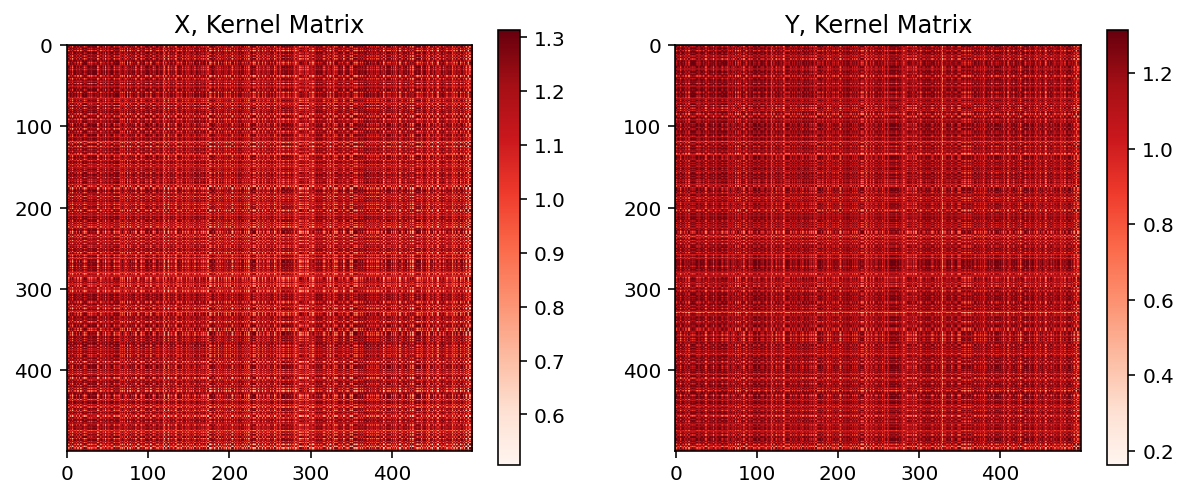

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(kernel_X(X,X), cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(kernel_Y(Y, Y), cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Kernel Matrix")
plt.show()

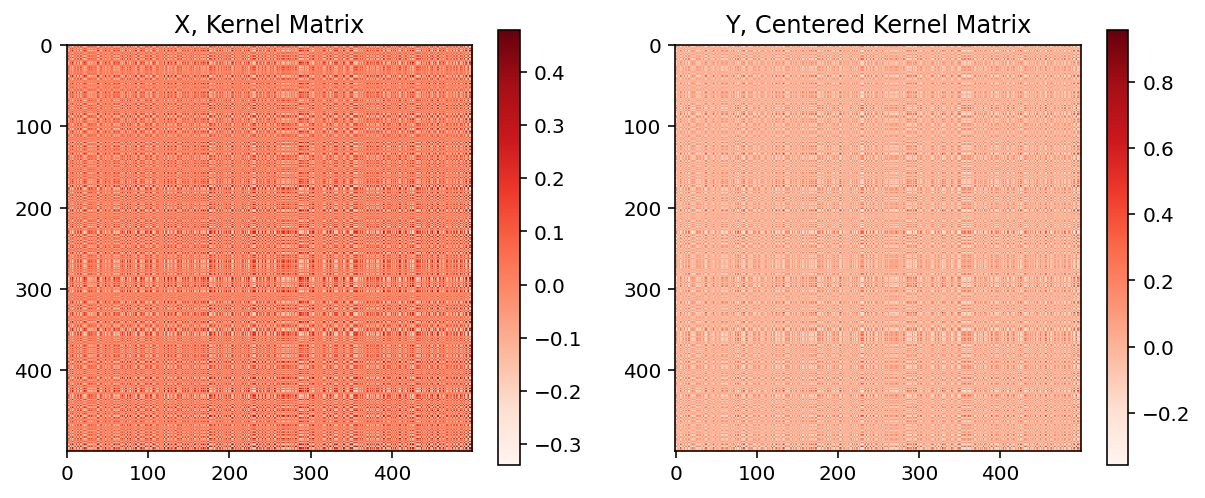

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(centering(kernel_X(X,X)), cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(centering(kernel_Y(Y,Y)), cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Centered Kernel Matrix")
plt.show()

In [14]:
# initialize HSIC model
hsic_clf = CKA(kernel_X, kernel_Y, bias=True)

# calculate HSIC
hsic_val = hsic_clf(X, Y)
print(f"HSIC: {hsic_val:.4f}")

HSIC: 0.8940


#### Convenience Function

Let's be honest, most people are going to use the RBF kernel. It's universal, quick n dirty, and quite simple to interpretate. So I made a convenience function to help people deal with it.

In [15]:
sigma_f = estimate_sigma_median

nhsic_clf = CKARBF(sigma_f, sigma_f)

nhsic_value = nhsic_clf(X, Y)

print(f"HSIC: {nhsic_value:.4f}")

HSIC: 0.8940


## Other Kernels



### RBF Kernel


#### Kernel Function

$$
k(\mathbf{x,y}) = \exp \left( - \frac{||\mathbf{x-y}||_2^2}{2 \sigma^2}  \right)
$$

where the squared euclidean distance is defined by:

$$
||\mathbf{x-y}||_2^2 = \sum_{i}^N (\mathbf{x}_i - \mathbf{y}_i)^2
$$


### Non-Linear

In [1]:
X = onp.random.randn(n_samples, 1)
Y = X**2 + 0.3 * onp.random.randn(X.shape[0], X.shape[1])

plt.scatter(X, Y)

NameError: name 'onp' is not defined

#### Linear Kernel

In [17]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.0369


#### RBF Kernel

In [18]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.3681


### Periodic

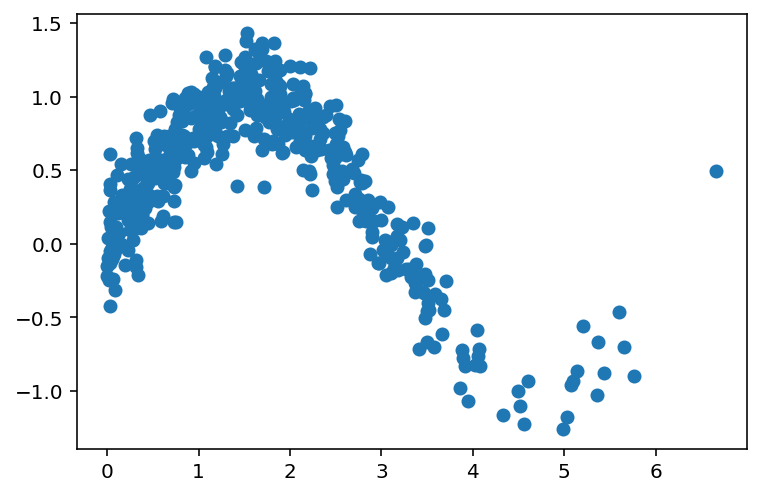

In [19]:
X = np.abs(2 * onp.random.randn(n_samples, 1))
Y = np.sin(X) + 0.2 * onp.random.randn(X.shape[0], X.shape[1])

plt.scatter(X, Y)

#### Linear Kernel

In [20]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.1890


#### RBF Kernel

In [21]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.3796


### Circle

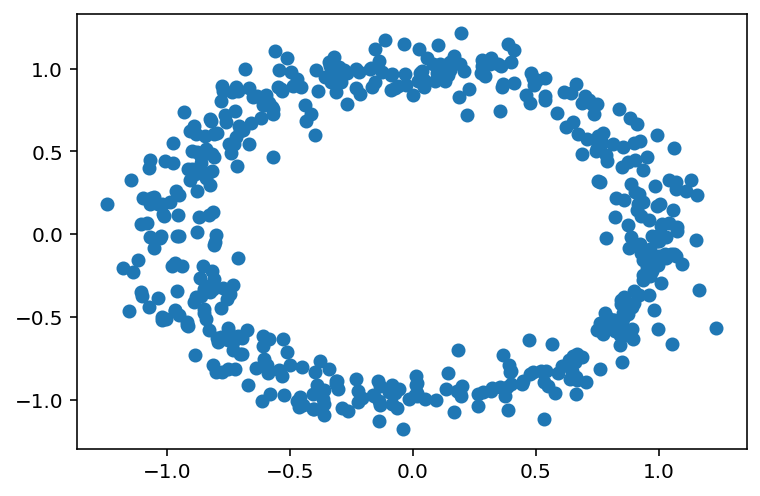

In [22]:
X, Y = generate_data(n_samples, "circle", noise_y=0.1, noise_x=0.1)

plt.scatter(X, Y)

#### Linear Kernel

In [23]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.0006


#### RBF Kernel

In [24]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.0357


### Random

In [36]:
X, Y = generate_data(n_samples, "random", noise_y=noise_y)

#### Linear Kernel

In [43]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.2e}")

nHSIC (Linear): 2.88e-03


#### RBF Kernel

In [44]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.2e}")

nHSIC (RBF): 2.93e-03


## MMD Equivalent

In [28]:
X, Y = generate_data(n_samples, "linear", noise_y=noise_y)

In [29]:
# linear kernel
K_x = lin_kern(X, X)
K_y = lin_kern(Y, Y)

# center matrices
K_xc = centering(K_x)
K_yc = centering(K_y)

In [30]:
# get the expectrations
A = np.mean(K_xc * K_yc)
B = np.mean(np.mean(K_xc, axis=0) * np.mean(K_yc, axis=0))
C = np.mean(K_xc) * np.mean(K_yc)

In [31]:
print(f"A: {A:.2e}")
print(f"B: {B:.2e}")
print(f"C: {C:.2e}")

A: 6.84e-03
B: -1.03e-16
C: -3.26e-19


In [33]:
# calculate MMD
mmd_value = A - 2 * B + C

print(f"MMD: {mmd_value:.4f}")

MMD: 0.0068
